In [1]:
import numpy as np
from meshplot import plot, subplot, interact
import igl
import scipy
import os
root_folder = os.getcwd()

In [2]:
from src.generate_mesh import triangular_lattice
from src.generate_mesh import create_mesh
from src.generate_mesh import linked_list_cell
from src.elastic_energy import Elastic_Local
from src.MC_vertex_link import MCstep_vertexB
from src.MC_vertex_link import MCstep_linkB
from src.particles import particlesA

triangular_lattice = np.array( triangular_lattice(1.1, expansion_level =15) ) # returns a list with points on the Euclidean plane (2d space)
ver, TRI=create_mesh(triangular_lattice)
header,linklis,L=linked_list_cell(ver)
ev,et,te=igl.edge_topology(ver,TRI) #ev edges as pair of vertices, et triangle edge relation, te edge triangle relation, -1 for boundaries
gen=igl.adjacency_matrix(TRI)
neig=scipy.sparse.lil_matrix(gen) #lil more efficint sparse format
border=igl.is_border_vertex(ver,TRI)

border=igl.is_border_vertex(ver,TRI) #fix border edges before calculating face normals, if not create discrepancy
ver_bulk=[]
for i in range(0,len(border)):
    if border[i]==False:
        ver_bulk.append(i)
    else:
        ver[i]=[ver[i][0],ver[i][1],0]

normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)
z=np.array([1/3,1/3,1/3])
z=z/np.linalg.norm(z)
normals_face=igl.per_face_normals(ver,TRI,z) #z normal given to degenerate faces(??)
area = igl.doublearea(ver, TRI) / 2.0
neigh=igl.adjacency_list(TRI)
ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))

1
(-1.6500000000000001, 0.9526279441628825)
1
(-2.75, 0.9526279441628824)
2
(-2.2, 1.9052558883257649)
1
(-3.8500000000000005, 0.9526279441628825)
2
(-3.3000000000000003, 1.905255888325765)
3
(-2.75, 2.8578838324886475)
1
(-4.95, 0.9526279441628825)
2
(-4.4, 1.905255888325765)
3
(-3.8499999999999996, 2.857883832488648)
4
(-3.3, 3.81051177665153)
1
(-6.050000000000001, 0.9526279441628824)
2
(-5.5, 1.9052558883257649)
3
(-4.95, 2.8578838324886475)
4
(-4.4, 3.8105117766515297)
5
(-3.8500000000000005, 4.763139720814412)
1
(-7.150000000000001, 0.9526279441628824)
2
(-6.600000000000001, 1.9052558883257649)
3
(-6.050000000000001, 2.8578838324886475)
4
(-5.500000000000001, 3.8105117766515297)
5
(-4.950000000000001, 4.763139720814412)
6
(-4.4, 5.715767664977295)
1
(-8.25, 0.9526279441628825)
2
(-7.700000000000001, 1.905255888325765)
3
(-7.15, 2.8578838324886475)
4
(-6.6000000000000005, 3.81051177665153)
5
(-6.050000000000001, 4.763139720814412)
6
(-5.5, 5.715767664977295)
7
(-4.95, 6.6683956091

In [3]:
len(ver)

721

In [4]:
plot(ver,TRI)

/home/riccardo/miniconda3/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [14]:
k=0.0001
β=0.1
r=1.0
σ=0.1*r
normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)  
#if want updated ELastic Local need to calculate again normals ver which are not updated by MC



k_I=10e-3
k_D=100
g=150

μ=0.2
#part=np.zeros(len(TRI))
#part[0]=0


H,M,A_v,SHO2,h2=Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border,μ,part)
H/k

1705.8123679369614

In [6]:
part

array([0., 0., 0., ..., 0., 0., 0.])

In [122]:
%timeit particlesA(ver,TRI,H,k,k_I,k_D,g,μ,SHO,h,M,A_v,normals_face,normals_ver,part,et,ev,te,border,neigh)

851 ms ± 161 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


for i in range(0,len(ver)):
    if abs(h[i]-h2[i])>10e-10:
        print(h[i],h2[i],i)

#to check it updates Shape operator correctly
for i in range(0,len(ev)):
    if abs(SHO[0,0,i]-SHO2[0,0,i])>10e-10:
            print(SHO[0,0,i],SHO2[0,0,i]," ",i)
            print(SHO[:,:,i]," ",SHO2[:,:,i])

In [11]:
nlinks=0
nvert=0
for z in range(0,100): 
    H_new=MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,M,A_v,normals_face,ADJ,NI,neigh,et,ev,te,SHO,ver_bulk,border,area,h,part,μ)
    H=H_new
    H_new,ADJ_new,NI_new=MCstep_linkB(ver,TRI,H,neig,β,M,k,r,ev,et,te,area,normals_face,ADJ,NI,SHO,border,A_v,h,part,μ)
    H=H_new
    ADJ,NI=ADJ_new,NI_new
    neigh=igl.adjacency_list(TRI) #Can update locally in MCstep_link
    normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)  
    part,H=particlesA(ver,TRI,H,k,k_I,k_D,g,μ,SHO,h,M,A_v,normals_face,normals_ver,part,et,ev,te,border,neigh,ADJ,NI)

flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt
flip attempt

In [12]:
H/k

1705.812367936966

In [13]:
plot(ver, TRI, c=part)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [104]:
%timeit MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,M,A_v,normals_face,ADJ,NI,neigh,et,ev,te,SHO,ver_bulk,border,area,h,part,μ)

5.91 s ± 379 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
N  T #MCstep_vertex time for a sweep in ms
91  314ms
397 1.73s
721 3.13s
1261 5.9s
1387 6.15s

In [ ]:
N T #particles time in ms(try to insert in all empty sites and try to diffuse all present particles)
91  82ms
331 354ms #time for first runs, for small system after first get faster because fill with particles
721 851ms
1261 1.39s

Text(0, 0.5, 'time for a sweep in ms')

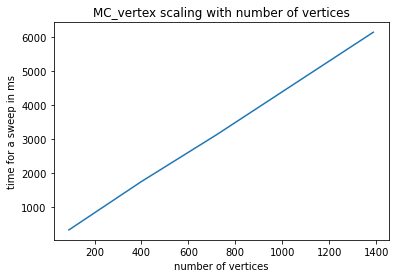

In [124]:
from matplotlib import pyplot as plt
plt.plot([91,397,721,1387],[314,1730,3130,6150])
plt.title("MC_vertex scaling with number of vertices")
plt.xlabel("number of vertices")
plt.ylabel("time for a sweep in ms")

Text(0, 0.5, 'time for a sweep in ms')

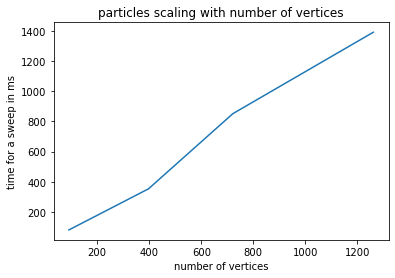

In [125]:
from matplotlib import pyplot as plt
plt.plot([91,397,721,1261],[82,354,851,1390])
plt.title("particles scaling with number of vertices")
plt.xlabel("number of vertices")
plt.ylabel("time for a sweep in ms")

In [133]:
%timeit update_energy_neig(ver,TRI,H,c1,c2,k,A_v,0,normals_face,neigh,ADJ,NI,area,SHO,et,border)

4.02 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
%timeit update_energy_vertex(ver,TRI,H,c1,c2,k,A_v,1,normals_face,neigh,ADJ,NI,area,SHO,et)

2.73 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
